# In this example we will read the information from a fluid file, calculate an integral quantity, interpolate to a regular mesh and obtain a 2d plot. 

## Import general modules

In [3]:
# Import required modules
from mpi4py import MPI #equivalent to the use of MPI_init() in C
import matplotlib.pyplot as plt
import numpy as np

# Get mpi info
comm = MPI.COMM_WORLD

# Import modules from pynek

In [4]:
from pynektools.ppymech.neksuite import preadnek
from pynektools.datatypes.msh import msh_c
from pynektools.datatypes.coef import coef_c
from pynektools.datatypes.field import field_c

# Construct the mesh and the coefficients

## Read the mesh data

In [5]:
fname = "../data/rbc0.f00001"
data = preadnek(fname, comm)

## Construct the mesh object from the read data

This object contains the mesh coordinates and some extra info like the element offset of each rank.

In [6]:
msh = msh_c(comm, data = data)

## Construct the coefficients

This object contains the terms of the jacobian, the terms of the jacobian inverse, the jacobian determinant, the mass matrix, and helper functions to allow the 

In [7]:
coef = coef_c(msh, comm)

# Read the mean fields and average them in time

the field object takes the data from the fld file and puts it in a dictionary structure

For this case we will only take the the dissipation of kinetic and thermal energy and average over all the statistics files we have.

In [20]:
# Write the IO information
path = "../data/"
fld_fname = "rbc"
index = 1

fld_data = preadnek(path+fld_fname+"0.f"+str(index).zfill(5), comm)
fld = field_c(comm, data = fld_data)

t = fld.t
w = fld.fields["vel"][2]

# Calculate the average

For the integral, we can use the mass matrix of the mesh that has been calculated in coef.

In [21]:
# Calculate the integrals
bar_w = np.sum(np.multiply(w, coef.B))/np.sum(coef.B)

print("Average: {}".format(bar_w))

Average: -1.4410692529985903e-08


Since RBC does not have an inflow/outflow. It is expected that on average, the velocity will be zero

# Let us get a 2D visualization

## Build a polar mesh

Start by constructing a polar mesh that can be used to interpolate the data, then we can easily average in the azimuthal direction. Since these values are scalar, we do not need to worry too much about projections.

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget

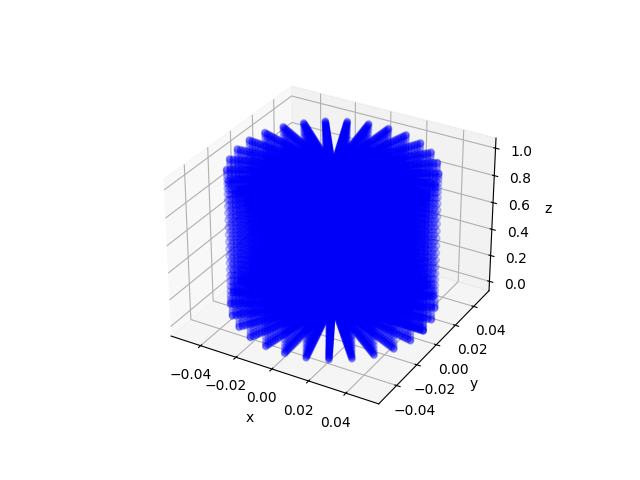

In [23]:
def generate_1d_arrays(bbox, n, mode="equal"):
    if mode=="equal":
        x_1d = np.linspace(bbox[0], bbox[1], n)
    elif mode=="cheb":
        x_1d = np.zeros(n)
        i = 0
        for k in range(1, n+1):
            # These are the chebyshev of the first kind (-1,1)
            #x_1d[i]=np.cos(((2*k-1)/(2*n))*np.pi)
            # These are the chebyshev of the second kind [-1,1]
            x_1d[i]= 1/2*(bbox[0]+bbox[1]) + 1/2*(bbox[1]-bbox[0]) * np.cos(((k-1)/(n-1))*np.pi)
            i = i+1
        x_1d = np.flip(x_1d)
    return x_1d  

# boundaries
x_bbox = [0, 0.05]
y_bbox = [0, 2*np.pi]
z_bbox = [0 , 1]

# Number of points
nx = 30
ny = 30
nz = 30

# Generate the points in 1D
x_1d = generate_1d_arrays(x_bbox, nx, mode="equal")
y_1d = generate_1d_arrays(y_bbox, ny, mode="equal")
z_1d = generate_1d_arrays(z_bbox, nz, mode="cheb")

# Now fill the 3d arrays
r, th, z = np.meshgrid(x_1d, y_1d, z_1d, indexing='ij')
x = r*np.cos(th)
y = r*np.sin(th)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='b', marker='o', alpha=0.2)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')       
plt.show()

## Now reshape the 3D space into a 2d array that contains a "pointcloud"

The probes object either reads as csv, or it takes an array of size (number_of_point, 3), the 3 standing for the 3 coordinates of a point in 3D.

In [24]:
def linear_index(i,j,k,lx,ly,lz):
    l = 0
    return (i + lx * ((j - 0) + ly * ((k - 0) + lz * ((l - 0)))))

def transform_from_array_to_list(nx,ny,nz,array):

    xyz_coords = np.zeros((nx*ny*nz,len(array)))
    for k in range(0,nz):
        for j in range(0,ny):
            for i in range(0,nx):
                position = linear_index(j,i,k,ny,nx,nz)
                for ind in range(0,len(array)):
                    xyz_coords[position,ind] = array[ind][i,j,k]

    return xyz_coords

xyz = transform_from_array_to_list(nx,ny,nz,[x, y, z])

## Perform the interpolation
First import the required modules for interpolation

In [25]:
# Import required modules
from pynektools.interpolation.probes import probes_c

### Initialize the probe object
Here as an input, introduce the point cloud that was generated before and the mesh. The probe object will then search for the points

In [26]:
# Intance the probe object
probes = probes_c(comm, probes = xyz, msh = msh, progress_bar = True)

finding points
rank: 0, finding points. start iteration: 0. Color: 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27000/27000 [00:51<00:00, 520.96it/s]


rank: 0, finding points. finished iteration: 0. time(s): 52.567947797
found data
redistributed data
writing .csv file as ./interpolated_fields.csv


### Perform the interpolation from a list of fields

In [27]:
probes.interpolate_from_field_list(t, [w], comm)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27000/27000 [00:25<00:00, 1070.48it/s]


Rank: 0, interpolated field: 0
writing .csv file as ./interpolated_fields.csv


### Map back from a list of points to the 3D arrays to facilitate the processing


In [28]:
# Inverse transformation to "linear index"
def nonlinear_index(linear_index, lx,ly,lz):
    index = np.zeros(4,dtype=int)
    lin_idx = linear_index
    index[3] = lin_idx/(lx*ly*lz)
    index[2] = (lin_idx-(lx*ly*lz)*index[3])/(lx*ly)
    index[1] = (lin_idx-(lx*ly*lz)*index[3]-(lx*ly)*index[2])/lx
    index[0] = (lin_idx-(lx*ly*lz)*index[3]-(lx*ly)*index[2]-lx*index[1])
    
    return index

def transform_from_list_to_array(nx,ny,nz,xyz_coords):

    num_points = xyz_coords.shape[0]

    try:
        len_array = xyz_coords.shape[1]
    except:
        len_array = 1 
        xyz_coords = xyz_coords.reshape(-1,1)

    array = []
    for i in range(0,len_array):
        array.append(np.zeros((nx,ny,nz)))

    for linear_index in range(0,num_points):
        index = nonlinear_index(linear_index,ny,nx,nz)
        j = index[0]
        i = index[1]
        k = index[2]
        for ind in range(0,len(array)):
            array[ind][i,j,k] = xyz_coords[linear_index,ind]

    return array


fields = transform_from_list_to_array(nx,ny,nz,probes.interpolated_fields)

the mapping gives a list of fields. The first entry in the list is always the time.

In [29]:
time = fields[0]
w_polar = fields[1]

## Average in the azimuthal direction and plot the results

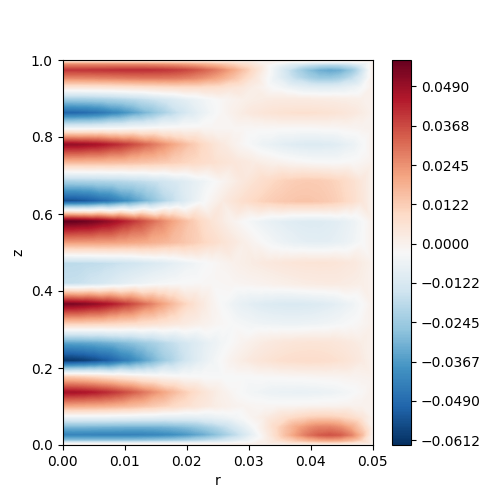

In [33]:
w_2d = np.mean(w_polar, axis=1)

levels = 500
cmapp='RdBu_r'
fig, ax = plt.subplots(1, 1,figsize=(5, 5))

c1 = ax.tricontourf(r[:,0,:].flatten(), z[:,0,:].flatten() ,w_2d.flatten(), levels=levels, cmap=cmapp)
fig.colorbar(c1)
ax.set_xlabel("r")
ax.set_ylabel("z")
plt.show()